In [1]:
# Import the required packages
import os
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import librosa.display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import librosa

In [2]:
# Get the data directories
data_dir = "../Speaker-Identification/16000_pcm_speeches/"
os.listdir(data_dir)

['Benjamin_Netanyau',
 'Jens_Stoltenberg',
 'Julia_Gillard',
 'Magaret_Tarcher',
 'Nelson_Mandela',
 'other',
 'tf_Wav_reader.py',
 '_background_noise_']

# Process training dataset

In [3]:
# get wav paths
def get_wav_paths(speaker):
    speaker_path = data_dir + speaker
    all_paths = [item for item in os.listdir(speaker_path)]
    return all_paths

In [4]:
nelson_mandela_paths = get_wav_paths("Nelson_Mandela")
margaret_thatcher_paths = get_wav_paths("Magaret_Tarcher")
benjamin_netanyau_paths = get_wav_paths("Benjamin_Netanyau")
jens_stoltenberg_paths = get_wav_paths( 'Jens_Stoltenberg')
julia_gillard_paths = get_wav_paths("Julia_Gillard")

noise1_paths = get_wav_paths("_background_noise_")
noise2_paths = get_wav_paths("other")

In [5]:
# load the data
def load_wav(wav_path, speaker):
    with tf.compat.v1.Session(graph=tf.compat.v1.Graph()) as sess:
        wav_path = data_dir + speaker + "/" + wav_path
        wav_filename_placeholder = tf.compat.v1.placeholder(tf.compat.v1.string, [])
        wav_loader = tf.io.read_file(wav_filename_placeholder)
        wav_decoder = tf.audio.decode_wav(wav_loader, desired_channels=1)
        wav_data = sess.run(
            wav_decoder, feed_dict={
                wav_filename_placeholder: wav_path
            }).audio.flatten().reshape((1, 16000))
        sess.close()
    return wav_data

In [6]:
# create training data
def generate_training_data(speaker_paths, speaker, label):
    wavs, labels = [], []
    for i in tqdm(speaker_paths):
        wav = load_wav(i, speaker)
        wavs.append(wav)
        labels.append(label)
    return wavs, labels


In [7]:
nelson_mandela_wavs, nelson_mandela_labels = generate_training_data(nelson_mandela_paths, "Nelson_Mandela", 0) 
margaret_thatcher_wavs, margaret_thatcher_labels = generate_training_data(margaret_thatcher_paths, "Magaret_Tarcher", 1) 
benjamin_netanyau_wavs, benjamin_netanyau_labels = generate_training_data(benjamin_netanyau_paths, "Benjamin_Netanyau", 2) 
jens_stoltenberg_wavs, jens_stoltenberg_labels = generate_training_data(jens_stoltenberg_paths, "Jens_Stoltenberg", 3) 
julia_gillard_wavs, julia_gillard_labels = generate_training_data(julia_gillard_paths, "Julia_Gillard", 4) 

100%|██████████| 1501/1501 [00:04<00:00, 326.24it/s]


In [8]:
# remove the extra wav for Julia Gillard
julia_gillard_labels = julia_gillard_labels[1:]
julia_gillard_wavs = julia_gillard_wavs[1:]

In [9]:
all_wavs = nelson_mandela_wavs + margaret_thatcher_wavs + benjamin_netanyau_wavs + jens_stoltenberg_wavs + julia_gillard_wavs
all_labels = nelson_mandela_labels + margaret_thatcher_labels + benjamin_netanyau_labels + jens_stoltenberg_labels + julia_gillard_labels

In [ ]:
from scipy.io.wavfile import read
from scipy.io.wavfile import write
from random import randint

def cut_random_section(noise2, size2):
    size21 = noise2.size
    starting_point2 = randint(0,(noise2.size - size2))
    end_point2 = starting_point2 + size2
    noise_cut_part2 = noise2[starting_point2:end_point2]
    return noise_cut_part2

def mix(audio1, noise1, snr1):
    audio_max = max(audio1)
    if audio_max==0:
        audio_max = int(np.random.uniform(0.7,1)*32767)
    audio1 = audio1*1.
    audio1 = audio1/audio_max
    noise1 = cut_random_section(noise1, audio1.size)
    noise1 = noise1*1.
    noise1 = noise1/max(noise1)
    gain = pow(10,(snr1/10.))
    numerator = np.mean(abs(audio1)**2)
    denominator = numerator/gain
    noise_power = np.mean(abs(noise1)**2)
    mult_value = (denominator/noise_power)**0.5
    noisy1 = audio1 + noise1*mult_value
    if max(audio1)==0:
        noisy1 = noise1
    else:    
        noisy1 = noisy1/max(noisy1)
    noisy1 = np.array(noisy1*audio_max, dtype='int16')
    return noise1*mult_value, mult_value, noisy1

noise_wavs = []
noise_labels = []
snr_dB = 10
for i in range(len(all_wavs)):
    for noise in os.listdir(data_dir + 'other'):
        fs, noise_file = read(data_dir + 'other/' + noise)
        x = all_wavs[i][0]
        noise_temp, mult_value, noisy = mix(x, noise_file, snr_dB)
        if noisy.any() != 0:
            noise_wavs.append(noisy)
            noise_labels.append(all_labels[i])
    for noise in os.listdir(data_dir + '_background_noise_'):
        fs, noise_file = read(data_dir + '_background_noise_/' + noise)
        x = all_wavs[i][0]
        if len(noise_file.shape) > 1:
            noise_file = np.reshape(noise_file, (noise_file.shape[0]*noise_file.shape[1]))
        noise_temp, mult_value, noisy = mix(x, noise_file, snr_dB)
        if noisy.any() != 0:
            noise_wavs.append(noisy)
            noise_labels.append(all_labels[i]) 
    if i%200 == 0:
        print(i)

In [11]:
for i in range(len(all_wavs)):
    noise_labels.append(all_labels[i])
    noise_wavs.append(all_wavs[i][0])
final_wavs = np.array(noise_wavs)
final_labels = np.array(noise_labels)

print(final_wavs.shape, final_labels.shape)

(8154, 16000) (8154,)


In [12]:
# split the dataset into trainin and testing set\
train_wavs, test_wavs, train_labels, test_labels = train_test_split(final_wavs, final_labels, test_size=0.1)

In [13]:
train_x, train_y = np.array(train_wavs), np.array(train_labels)
test_x, test_y = np.array(test_wavs), np.array(test_labels)

In [14]:
train_y = tf.keras.utils.to_categorical(train_y)
test_y = tf.keras.utils.to_categorical(test_y)

In [15]:
# import csv
# with open('train_x.csv', 'wt') as f:
#     csv_writer = csv.writer(f, quoting=csv.QUOTE_NONE)
#     csv_writer.writerows(train_x)
# with open('test_x.csv', 'wt') as f:
#     csv_writer = csv.writer(f, quoting=csv.QUOTE_NONE)
#     csv_writer.writerows(test_x)
# with open('train_y.csv', 'wt') as f:
#     csv_writer = csv.writer(f, quoting=csv.QUOTE_NONE)
#     csv_writer.writerows(train_y)
# with open('test_y.csv', 'wt') as f:
#     csv_writer = csv.writer(f, quoting=csv.QUOTE_NONE)
#     csv_writer.writerows(test_y)

In [16]:
# MFCC Feature Extraction

train_x_new = []
test_x_new = []
INPUT_SHAPE = (126,40)

train_x_new = np.zeros((train_x.shape[0], INPUT_SHAPE[0], INPUT_SHAPE[1]), dtype=np.float64)

count = 0
for sample in train_x:
    mfcc = librosa.feature.mfcc(y=sample, sr=16000, hop_length=128, n_fft=256, n_mfcc=20)
    mfcc_delta = librosa.feature.delta(mfcc)[:10, :]
    mfcc_double_delta = librosa.feature.delta(mfcc, order=2)[:10, :]
    train_x_new[count, :, :20] = mfcc.T
    train_x_new[count, :, 20:30] = mfcc_delta.T
    train_x_new[count, :, 30:] = mfcc_double_delta.T
    count += 1
    if count%500 == 0:
        print('Train', count)
        
test_x_new = np.zeros((test_x.shape[0], INPUT_SHAPE[0], INPUT_SHAPE[1]), dtype=np.float64)

count = 0
for sample in test_x:
    mfcc = librosa.feature.mfcc(y=sample, sr=16000, hop_length=128, n_fft=256, n_mfcc=20)
    mfcc_delta = librosa.feature.delta(mfcc)[:10, :]
    mfcc_double_delta = librosa.feature.delta(mfcc, order=2)[:10, :]
    test_x_new[count, :, :20] = mfcc.T
    test_x_new[count, :, 20:30] = mfcc_delta.T
    test_x_new[count, :, 30:] = mfcc_double_delta.T
    count += 1
    if count%500 == 0:
        print('Test', count)

c:\Users\dhvan\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Train 500
Train 1000
Train 1500
Train 2000
Train 2500
Train 3000
Train 3500
Train 4000
Train 4500
Train 5000
Train 5500
Train 6000
Train 6500
Train 7000
Test 500


In [17]:
train_x_new = np.expand_dims(train_x_new, axis=3)
test_x_new = np.expand_dims(test_x_new, axis=3)
print(train_x_new.shape, test_x_new.shape)

(7338, 126, 40, 1) (816, 126, 40, 1)


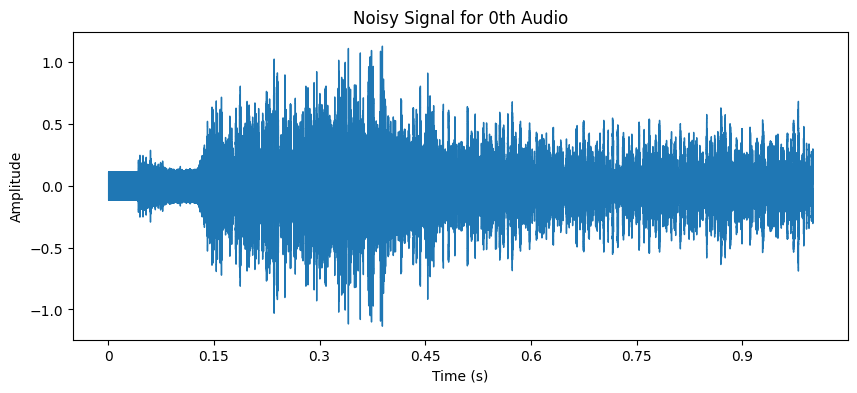

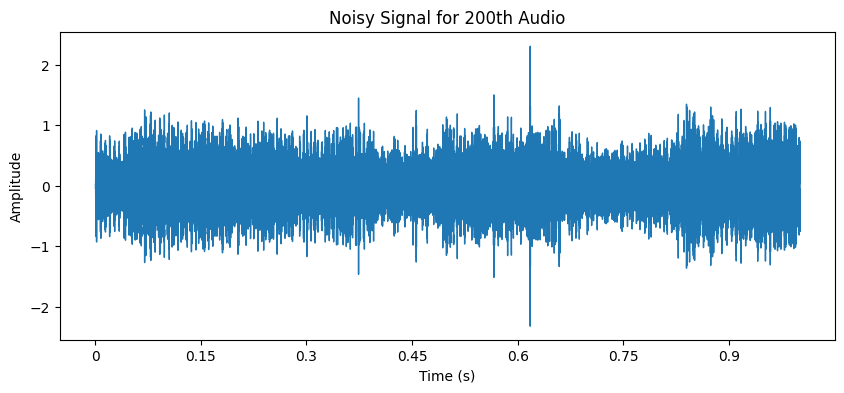

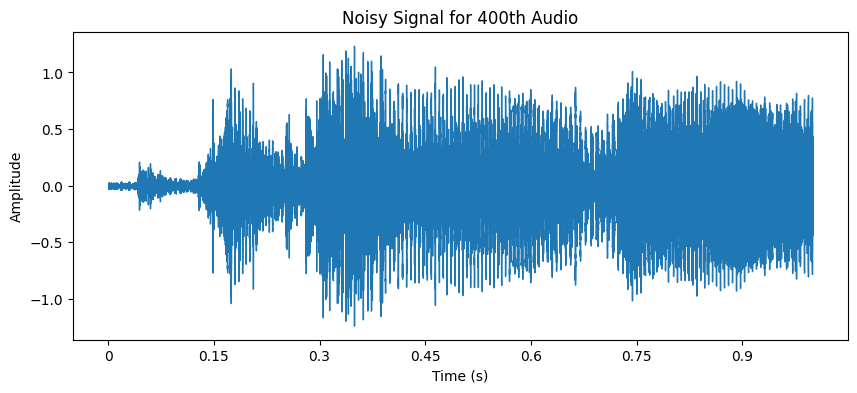

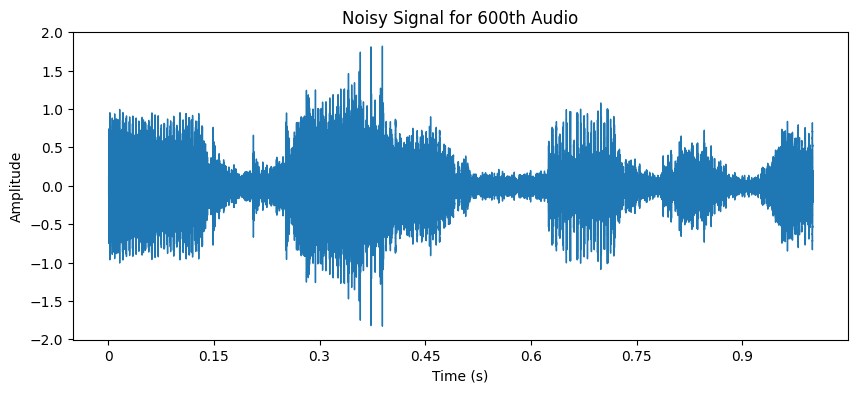

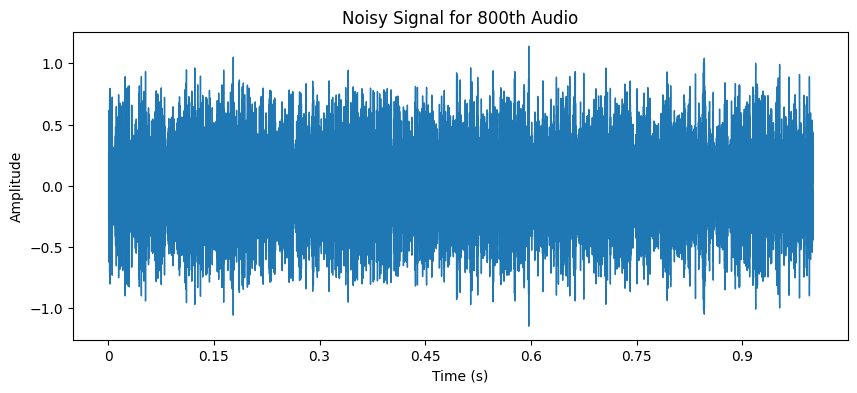

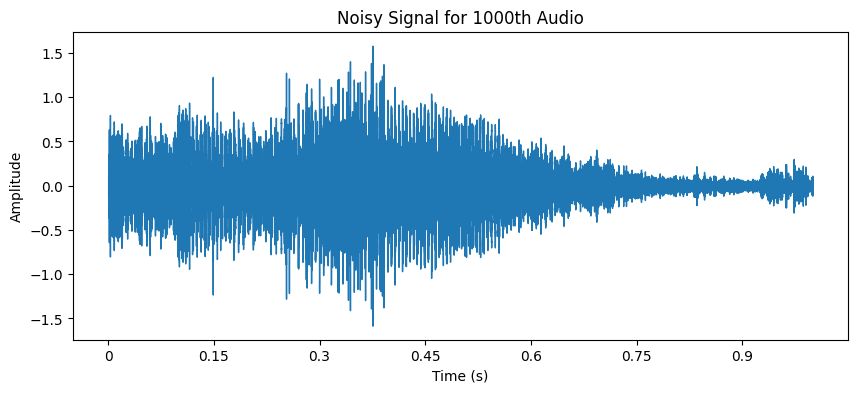

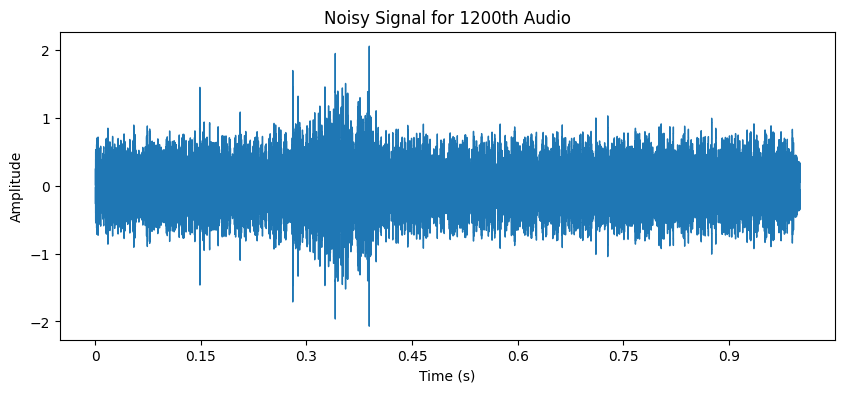

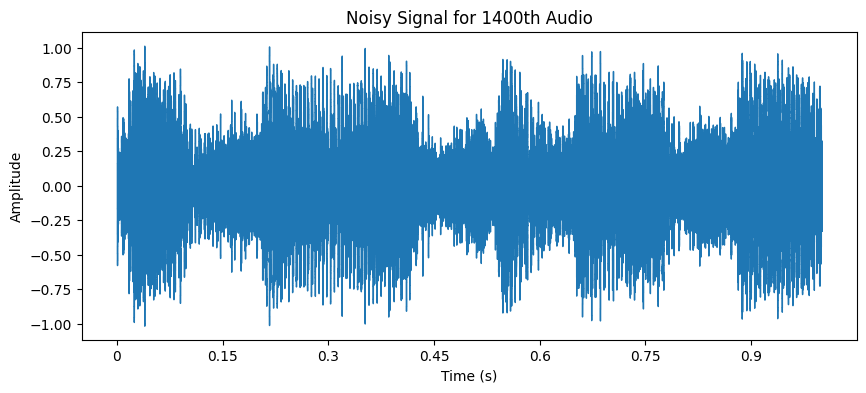

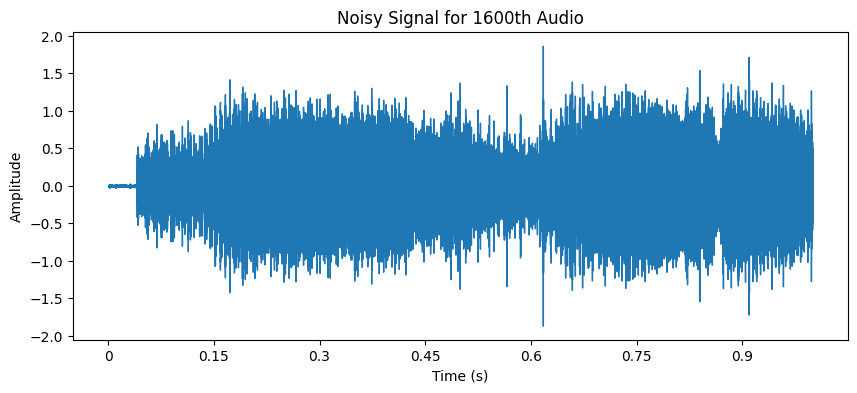

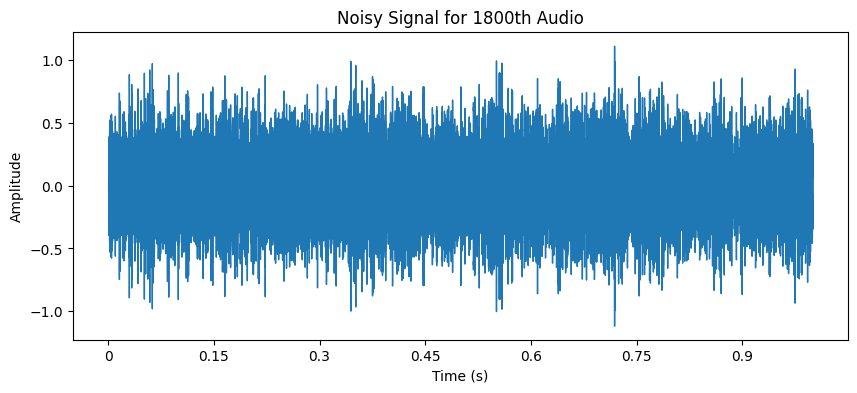

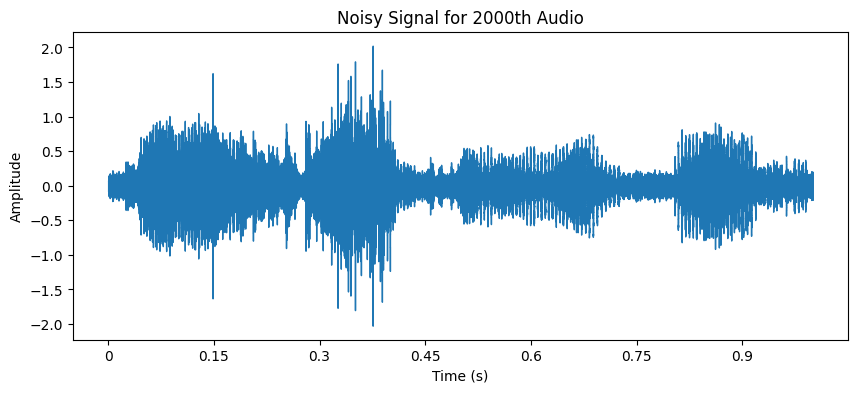

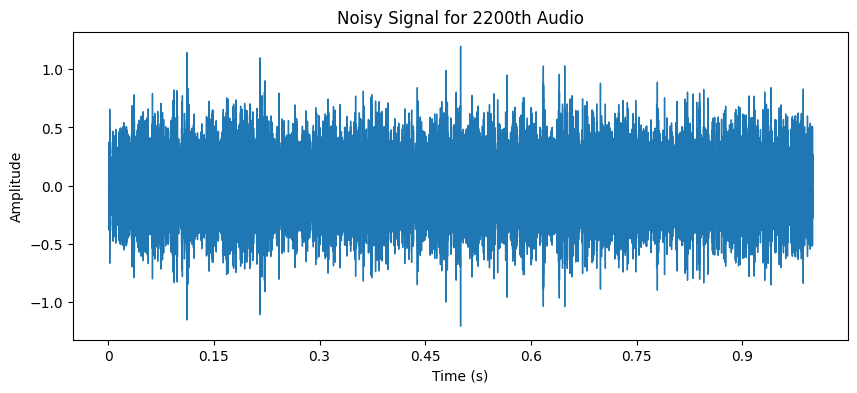

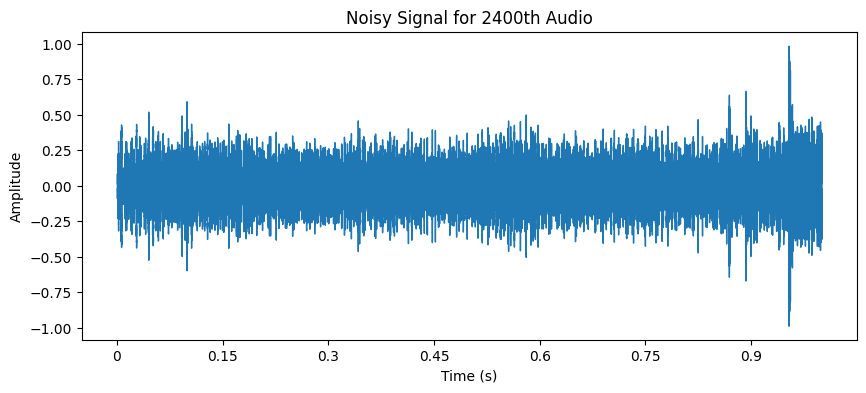

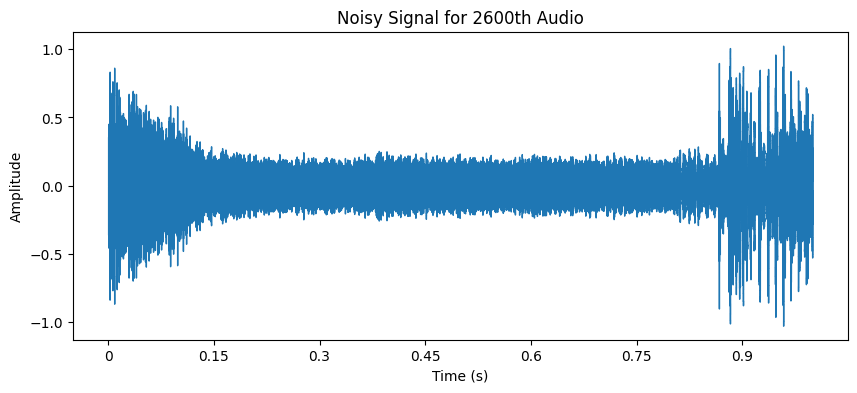

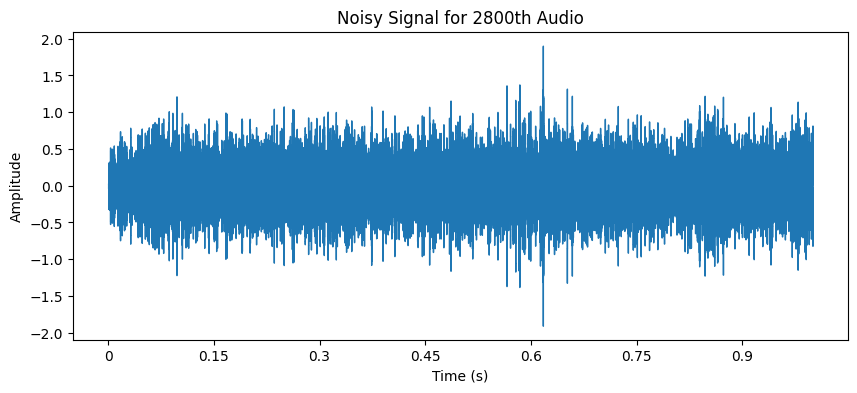

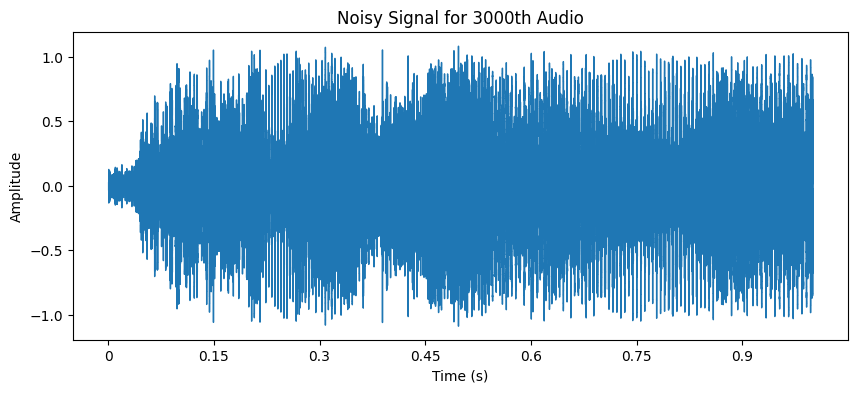

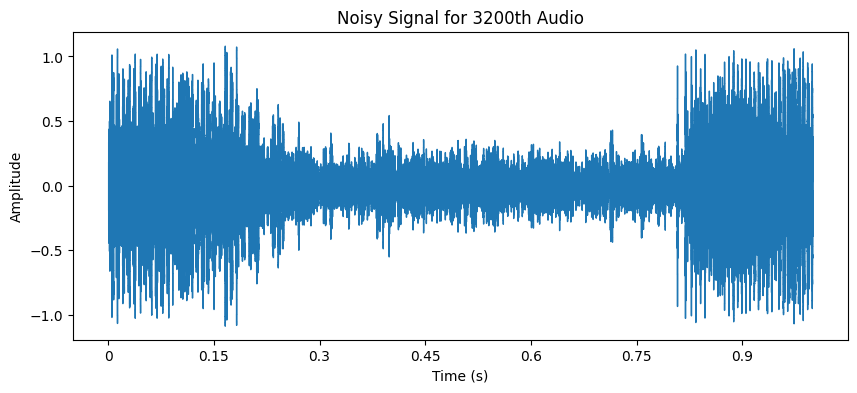

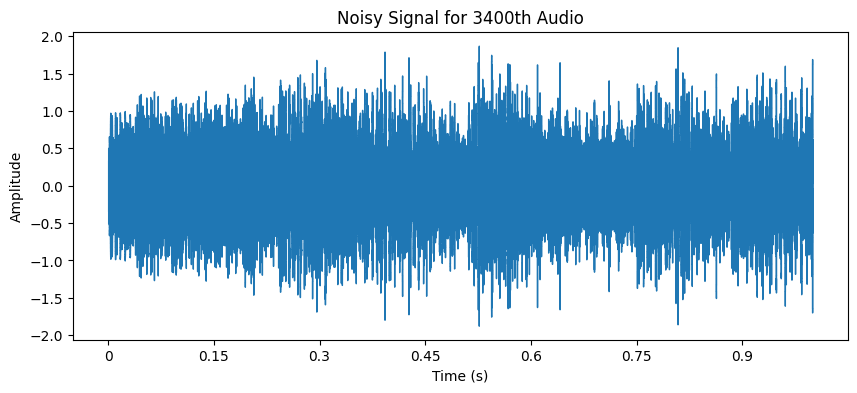

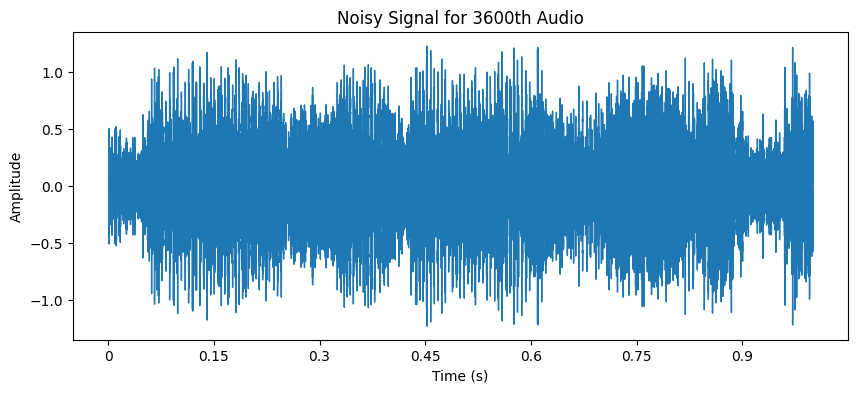

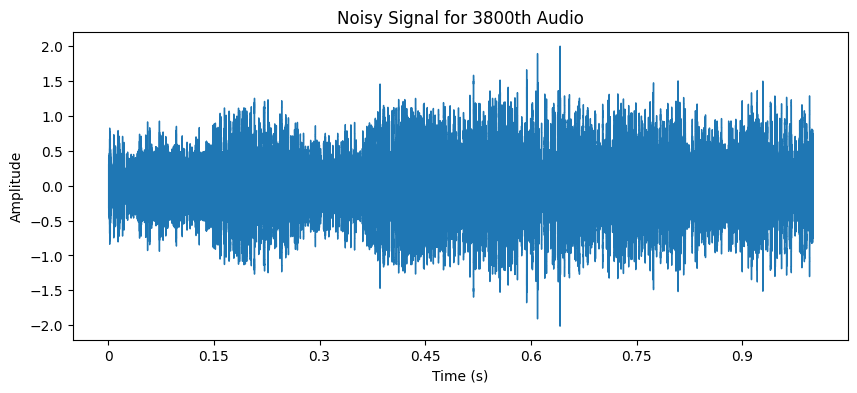

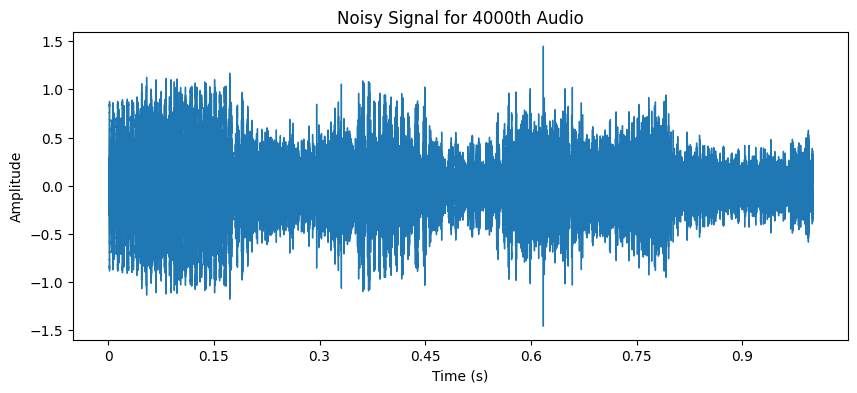

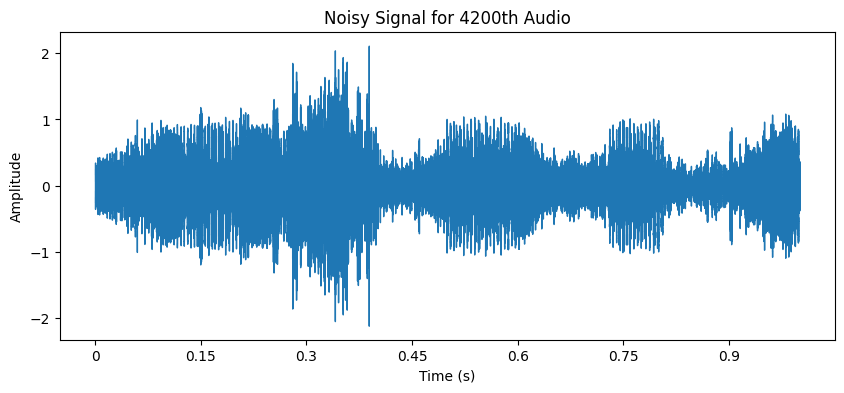

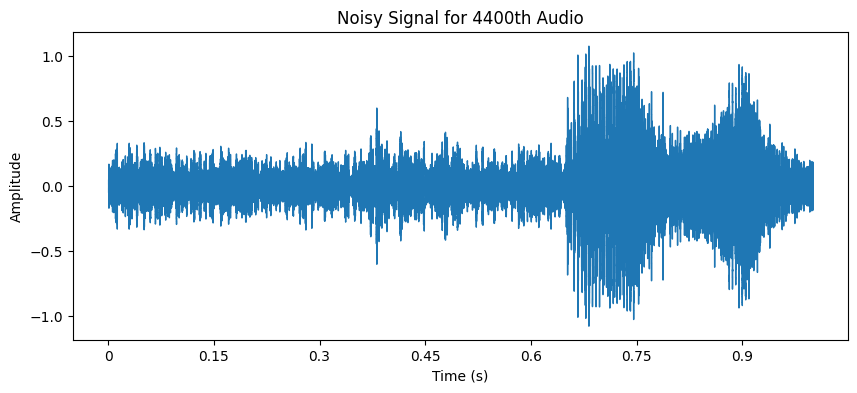

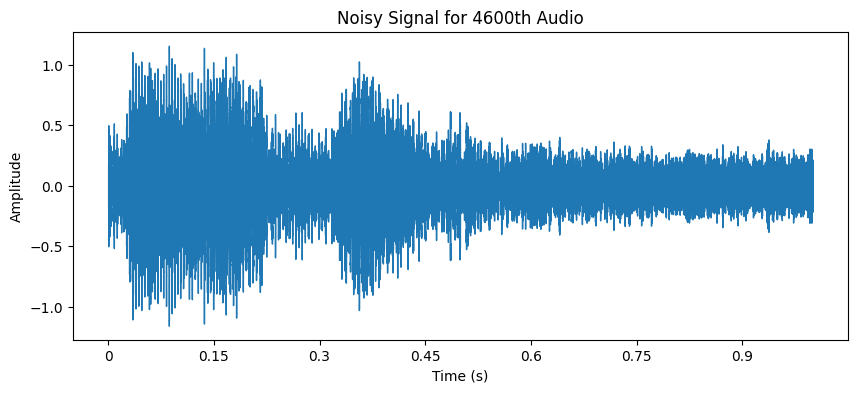

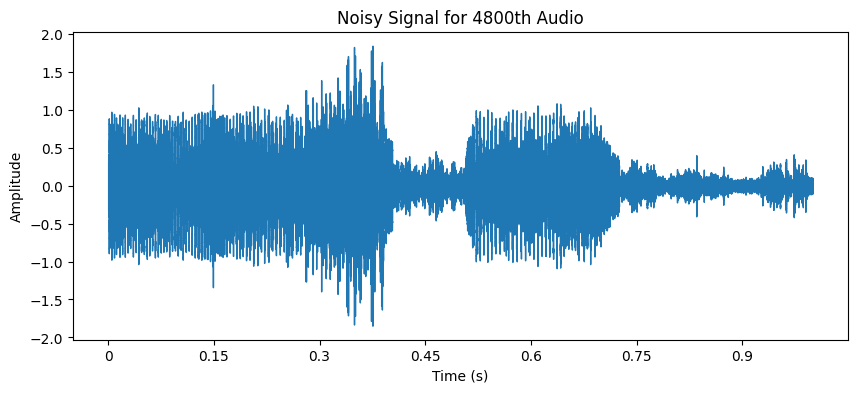

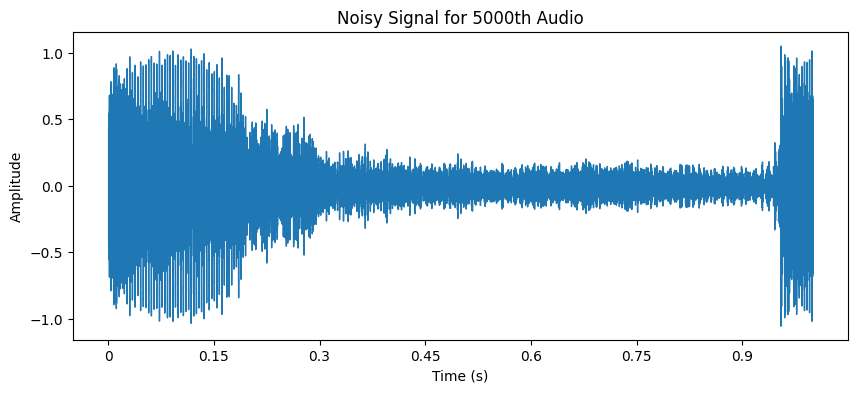

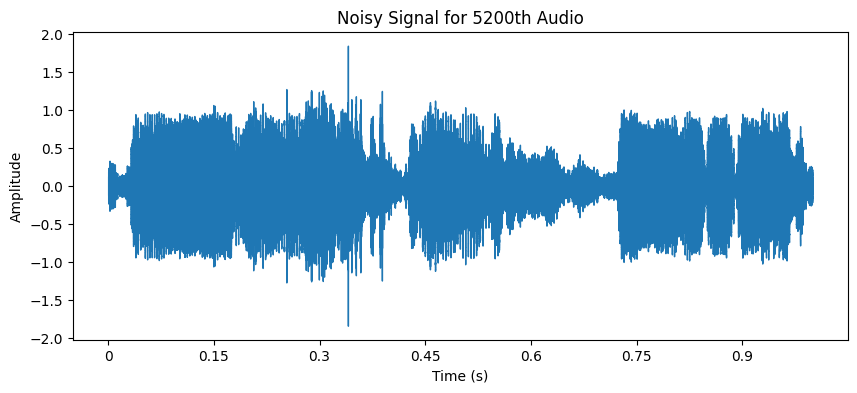

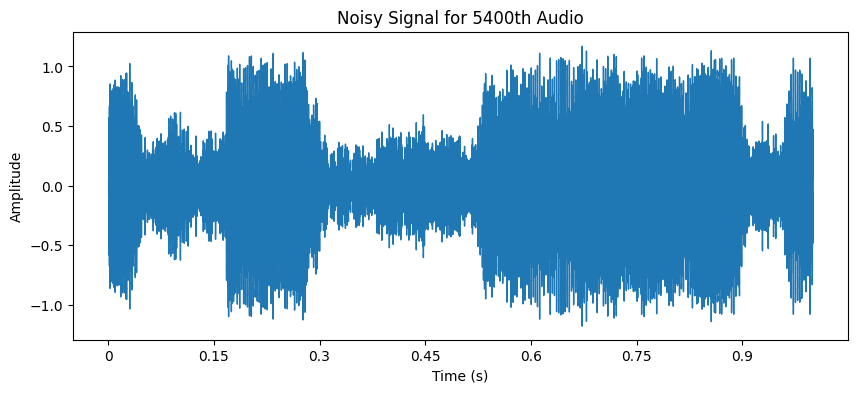

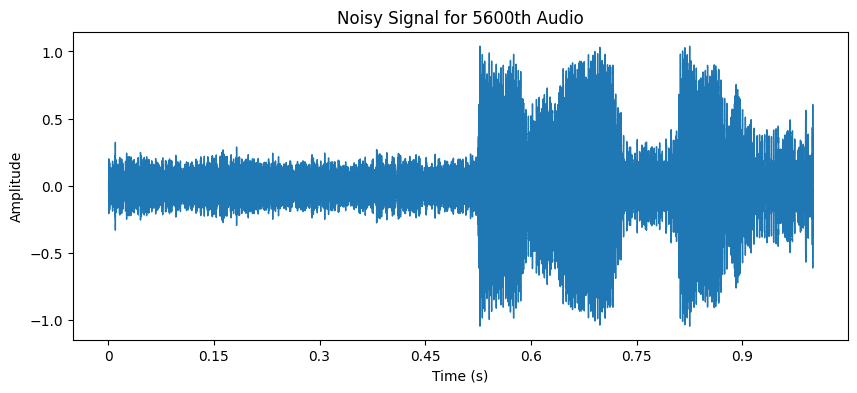

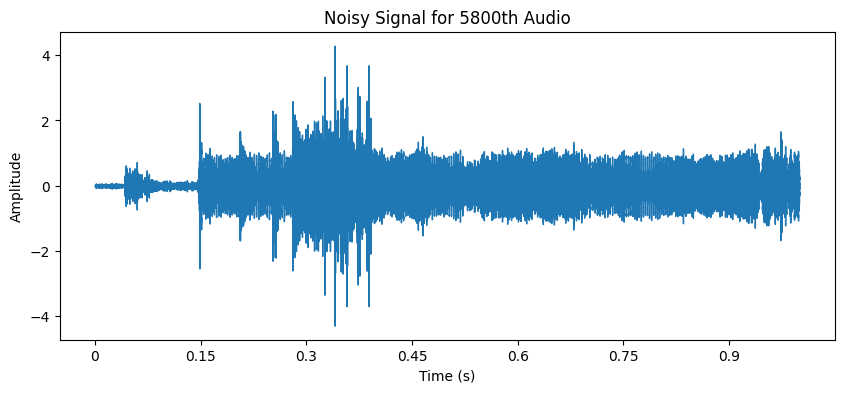

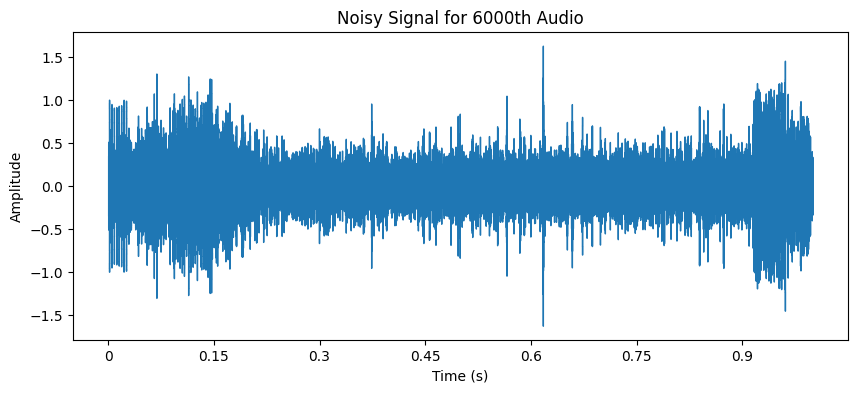

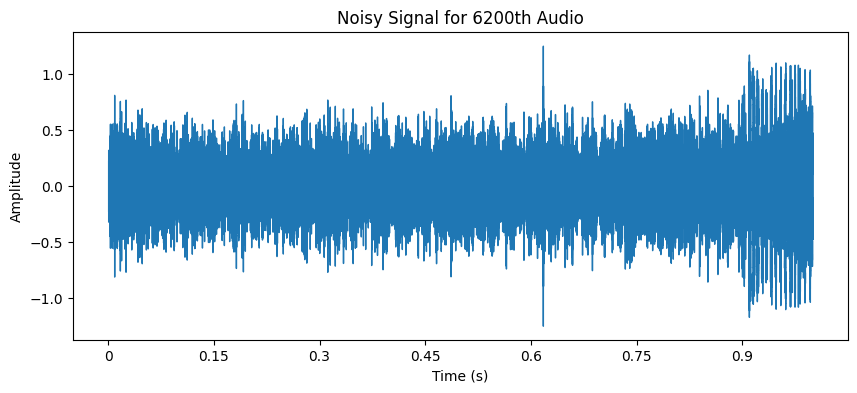

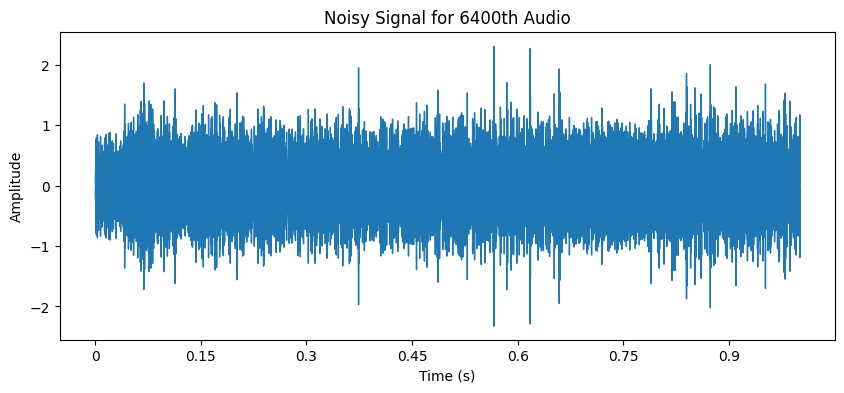

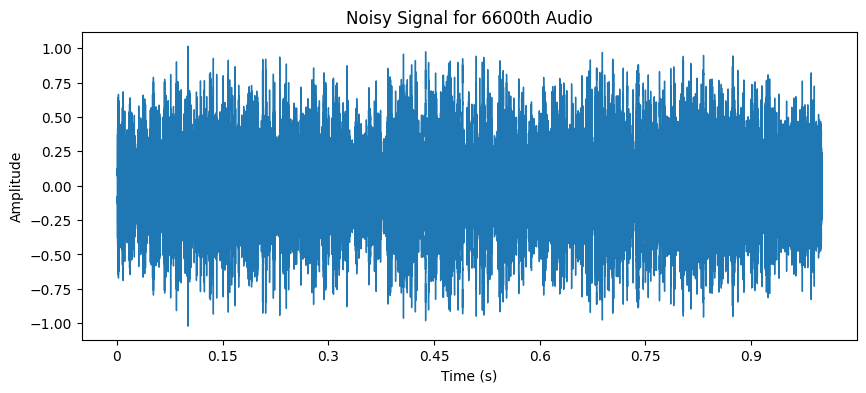

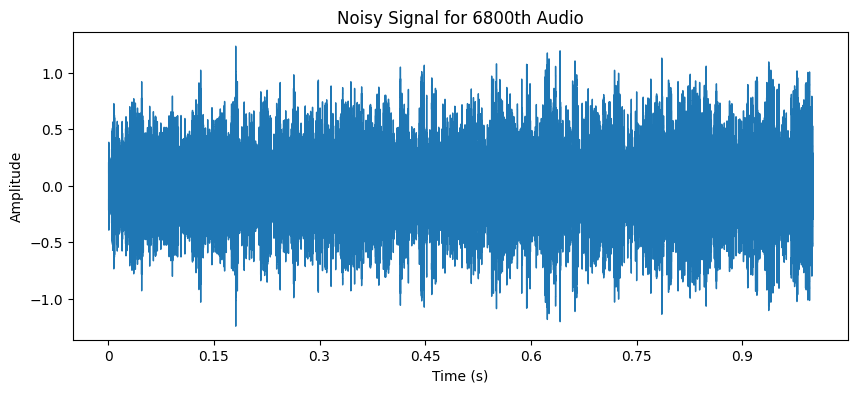

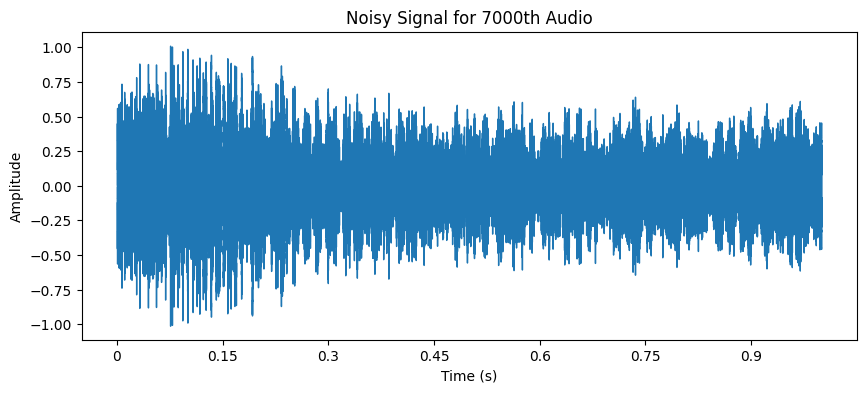

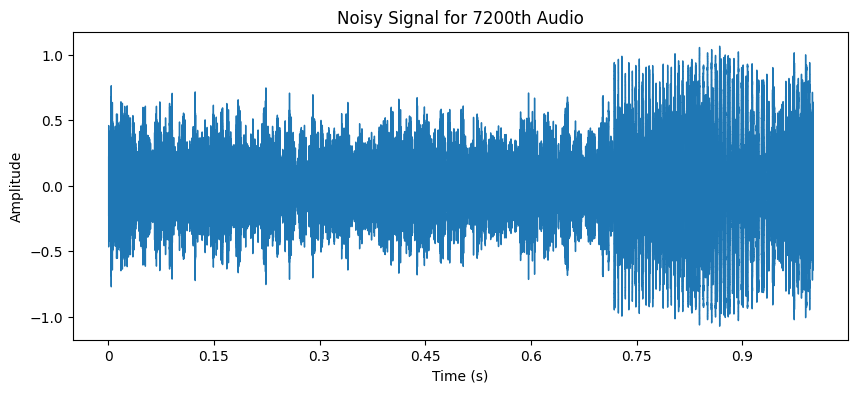

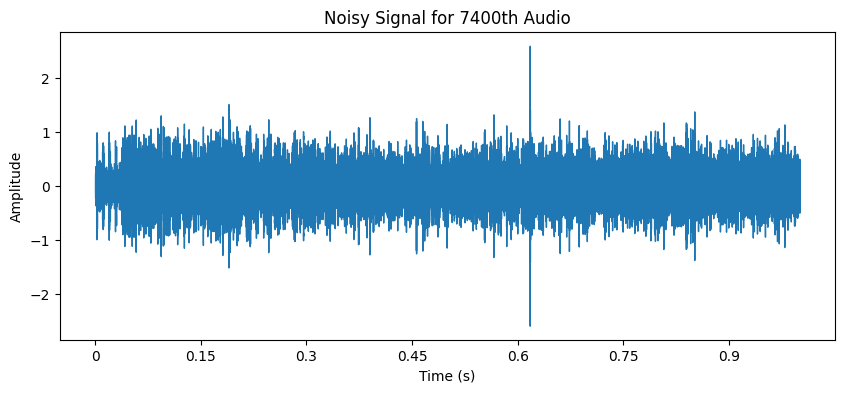

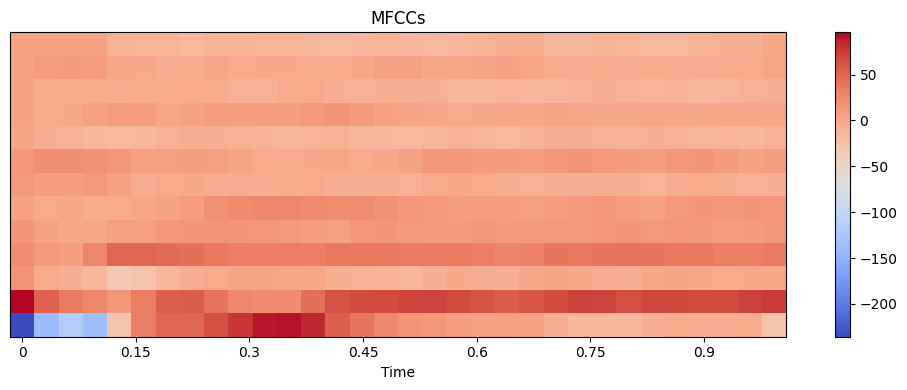

In [25]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def trim_silence(audio):
    y_trimmed, index = librosa.effects.trim(audio, top_db=20)
    return y_trimmed

def random_5sec_snippet(audio, sample_rate=16000):
    num_samples_for_5sec = 5 * sample_rate
    if len(audio) < num_samples_for_5sec:
        return audio
    start_idx = np.random.randint(0, len(audio) - num_samples_for_5sec)
    return audio[start_idx:start_idx + num_samples_for_5sec]

base_path = "../Speaker-Identification/16000_pcm_speeches/"
all_wavs = []
all_labels = []

# Loading speaker wavs
for speaker in os.listdir(base_path):
    if os.path.isdir(base_path + speaker) and speaker != "background_noise" and speaker != "other":
        for file in os.listdir(base_path + speaker):
            wav, _ = librosa.load(base_path + speaker + '/' + file, sr=16000)
            all_wavs.append([wav, len(wav) / 16000])
            all_labels.append(speaker)

# Loading noise wavs
noise_wavs = []
noise_dir = base_path + "_background_noise_/"
for file in os.listdir(noise_dir):
    wav, _ = librosa.load(noise_dir + file, sr=16000)
    noise_wavs.append(wav)

def get_noise_from_sound(signal, noise, SNR):
    RMS_s = np.sqrt(np.mean(signal ** 2))
    RMS_n = np.sqrt(RMS_s ** 2 / (pow(10, SNR / 10)))
    RMS_current = np.sqrt(np.mean(noise ** 2))
    noise = noise * (RMS_n / RMS_current)
    return noise

noisy_dataset = []
for i in range(len(all_wavs)):
    signal = np.interp(all_wavs[i][0], (all_wavs[i][0].min(), all_wavs[i][0].max()), (-1, 1))
    
    noise_idx = np.random.randint(0, len(noise_wavs))
    noise = noise_wavs[noise_idx]

    if len(signal) < len(noise):
        noise = get_noise_from_sound(signal, noise, np.random.uniform(0, 10))
        noise = noise[:len(signal)]
    else:
        signal = signal[:len(noise)]
        noise = get_noise_from_sound(signal, noise, np.random.uniform(0, 10))
    noisy = signal + noise
    noisy = random_5sec_snippet(noisy)
    noisy_dataset.append([noisy, all_labels[i]])
    if i % 200 == 0:
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(noisy, sr=16000)
        plt.title(f"Noisy Signal for {i}th Audio")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.show()

all_mfccs = []
for i in range(len(noisy_dataset)):
    mfccs = librosa.feature.mfcc(y=noisy_dataset[i][0], sr=16000, n_mfcc=13)
    delta = librosa.feature.delta(mfccs)
    double_delta = librosa.feature.delta(delta)
    combined = np.vstack((mfccs, delta, double_delta))
    all_mfccs.append([combined, noisy_dataset[i][1]])
    if i == 0:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfccs, x_axis='time', sr=16000)
        plt.colorbar()
        plt.title("MFCCs")
        plt.tight_layout()
        plt.show()
